## Hand-written digits Recognition Notebook

This notebook is intended to demonstrate the implementation of a Convolutional neural network model in Keras (backend TensorFlow) for recognising handwritten digits in images. The original paper could be found [here](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf). Before getting started, import any libraries that may be required.

In [1]:
#Import required libraries

#This module performs conversions between Python values and C structs represented as Python bytes objects.
import struct as st 
# Efficiently deals with numerical multi-dimensional arrays.
import numpy as np 
# Matplotlib is a plotting library. pyplot is its easy-to-use module.
import matplotlib.pyplot as plt
# Tensorflow backend keras
import tensorflow.keras as kr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## First method to read and convert mnist dataset in idx format into python numpy array

The next step is to load the data to train and test the model.The MNIST database of handwritten digits, available from [this page](http://yann.lecun.com/exdb/mnist/), has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

In [2]:
# Adapted from : https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1


filename = {'train_images' : './mnist_dataset/train-images.idx3-ubyte' ,'train_labels' : './mnist_dataset/train-labels.idx1-ubyte',
            'test_img':'./mnist_dataset/t10k-images.idx3-ubyte','test_lbl':'./mnist_dataset/t10k-labels.idx1-ubyte'}
# Open the IDX file in readable binary mode.
train_imagesfile = open(filename['train_images'],'rb')
train_labelsfile = open(filename['train_labels'],'rb')
test_imagesfile = open(filename['test_img'],'rb')
test_labelsfile = open(filename['test_lbl'],'rb')

# Set pointer to the beginning of the file.
train_imagesfile.seek(0)
train_labelsfile.seek(0)
test_imagesfile.seek(0)
test_labelsfile.seek(0)

# Read the magic number
magic_img = st.unpack('>4B',train_imagesfile.read(4))
magic_lab = st.unpack('>4B',train_labelsfile.read(4))
magic_test_img = st.unpack('>4B',test_imagesfile.read(4))
magic_test_lab = st.unpack('>4B',test_labelsfile.read(4))

# Read the dimensions of the Image data-set
train_images = st.unpack('>I',train_imagesfile.read(4))[0] #num of images
n_row_i = st.unpack('>I',train_imagesfile.read(4))[0] #num of rows
n_col_i = st.unpack('>I',train_imagesfile.read(4))[0] #num of column

test_images = st.unpack('>I',test_imagesfile.read(4))[0] #num of images
n_row_test = st.unpack('>I',test_imagesfile.read(4))[0] #num of rows
n_col_test = st.unpack('>I',test_imagesfile.read(4))[0] #num of column

# Read the dimensions of the Label data-set
train_labels = st.unpack('>I',train_labelsfile.read(4))[0] #num of items
test_labels = st.unpack('>I',test_labelsfile.read(4))[0] #num of items

# Reading the Image data
train_bytes_total = train_images*n_row_i*n_col_i*1 
test_bytes_total = test_images*n_row_test*n_col_test*1 

# 'B' is used since it is of 'unsigned char' C type and ‘integer’ Python type
# and has standard size 1 as mentioned in the official documentation of struct.
# ‘>’ is used since the data is in MSB first (high endian) format used by most 
# non-Intel processors, as mentioned in their original website.
train_img = 255 - np.asarray(st.unpack('>'+'B'*train_bytes_total,train_imagesfile.read(train_bytes_total))).reshape((train_images,n_row_i,n_col_i))
test_img =   255 - np.asarray(st.unpack('>'+'B'*test_bytes_total,test_imagesfile.read(test_bytes_total))).reshape((test_images,n_row_test,n_col_test))
 
# Reading the label data
train_lbl = np.asarray(st.unpack('>'+'B'*train_labels,train_labelsfile.read(train_labels))).reshape((train_labels))
test_lbl = np.asarray(st.unpack('>'+'B'*test_labels,test_labelsfile.read(test_labels))).reshape((test_labels))

# Close read files
train_imagesfile.close()
train_labelsfile.close()
test_imagesfile.close()
test_labelsfile.close()

print(test_img.shape)

(10000, 28, 28)


5


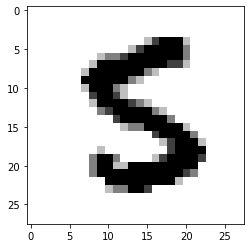

In [3]:
plt.imshow(test_img[132], cmap='gray')

print(test_lbl[132])


## Second method to load the MNIST dataset into Python numpy array

In order to load the data to train and test the model. For this we will use the MNIST data set available from Keras.

In [4]:
# import MNIST dataset with keras
import keras
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(type(x_train))
print('Train set of images are 3D array',x_train.shape)# 60000 of images in train set,sized by 28x28 pixals
print('Test set of images are 3D array',x_test.shape)# 10000 of images in test set

Using TensorFlow backend.


<class 'numpy.ndarray'>
Train set of images are 3D array (60000, 28, 28)
Test set of images are 3D array (10000, 28, 28)


#### Reshaping data

The datasets are 3D arrays. Training dataset shape is (60000, 28, 28) & Testing dataset shape is (10000, 28, 28). The input shape that CNN expects is a 4D array (batch, height, width, channels). Channels signify whether the image is grayscale or colored. In our case, we are using grayscale images so we give 1 for channels if these are colored images we give 3(RGB). Below code for reshaping our inputs

In [5]:
# Reshape to the expected CNN format 
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

print(x_train.shape)# 60000 images,28x28x1 

(60000, 28, 28, 1)


#### Data Preprocessing

- When our data is comprised of attributes with varying scales, many machine learning algorithms can benefit from rescaling the attributes to all have the same scale.
- This is useful for optimization algorithmsm used in the core of machine learning algorithms like gradient descent.

In [6]:
# scaling images to make gradient descent process faster
x_train=x_train/255
x_test=x_test/255

print(x_train[1].shape)

(28, 28, 1)


#### Encoding Categorical Values in Python

Categorical data are variables that contain label values rather than numeric values.
Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.
One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [7]:


# encoding categorical variables (one,two,three...) into numerical (1,2,3...)
# adapted from : https://pbpython.com/categorical-encoding.html

y_train = kr.utils.to_categorical(y_train, 10)
y_test = kr.utils.to_categorical(y_test, 10)


 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


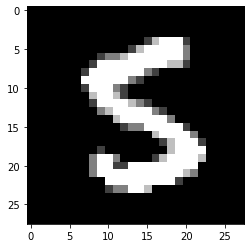

In [8]:
print(' 0, 1, 2, 3, 4, 5, 6, 7, 8, 9')
print(y_test[132])
plt.imshow(x_test[132].reshape(28, 28), cmap='gray')



### Convolutional Neural Network

A Convolutional Neural Network (CNN) is comprised of one or more convolutional layers (often with a subsampling step) and then followed by one or more fully connected layers as in a standard multilayer neural network. The architecture of a CNN is designed to take advantage of the 2D structure of an input image (or other 2D input such as a speech signal). This is achieved with local connections and tied weights followed by some form of pooling which results in translation invariant features. Another benefit of CNNs is that they are easier to train and have many fewer parameters than fully connected networks with the same number of hidden units.

A CNN consists of a number of convolutional and subsampling layers optionally followed by fully connected layers. The input to a convolutional layer is a m x m x r image where m is the height and width of the image and r is the number of channels, e.g. an RGB image has r=3,in our case we have only one channel thus r = 1.

The convolutional layer will have k filters (or kernels) of size n x n x q where n is smaller than the dimension of the image and q can either be the same as the number of channels r or smaller and may vary for each kernel. The size of the filters gives rise to the locally connected structure which are each convolved with the image to produce k feature maps of size m−n+1. Each map is then subsampled typically with mean or max pooling over p x p contiguous regions where p ranges between 2 for small images (e.g. MNIST) and is usually not more than 5 for larger inputs. Either before or after the subsampling layer an additive bias and sigmoidal nonlinearity is applied to each feature map.

![Convolutional neural network](./img/conv.jpeg)

#### Building the Convolutional Neural Network

Steps to build CNN
1. Provide the input image into convolution layer.
2. Take convolution with featured kernel/filters.
3. Apply pooling layer to reduce the dimensions.
4. Add these layers multiple times.
5. Flatten the output and feed into a fully connected layer.
6. Train the model with backpropagation using logistic regression.

    * The first layer of code is a hidden layer called a Convolution2D. The layer has 32 filters/output channels, which with the size of 3×3 and an activation function. This is also the input layer, expecting images with the structure outlined above (height, width, channels).(28x28x1)
    * The Second layer is the MaxPooling layer. MaxPooling layer is used to down-sample the input to enable the model to make assumptions about the features so as to reduce over-fitting. It also reduces the number of parameters to learn, reducing the training time.
    * The third layer is a hidden layer Convolution2D with 64 filters/output channels with the size of 3×3 and an activation function.Because it is not the first layer there is no need for input_shape parameters.
    * The forth layer is a MaxPooling layer.
    * The sixth layer converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by a fully connected neural network.
    * The seventh is a fully connected layer with 128 neurons.
    * The eighth and final layer is an output layer with 10 neurons and it uses softmax activation function. Each neuron will give the probability of that class. It’s a multi-class classification that’s why softmax activation function if it was a binary classification we would use sigmoid activation function.



In [9]:
# Initialising the CNN
model = Sequential()
#  Implements the forward propagation for the model:
#   CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

# Convolution layer
model.add(Conv2D(32,(3,3),strides=(1, 1),input_shape = (x_train.shape[1],x_train.shape[2],1),activation = 'relu',padding='same'))

# Pooling as reducing feature map
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# Apply 64 filters sized of (3x3) on 2nd convolution layer
model.add(Conv2D(64,kernel_size=(3,3),strides=(1, 1),activation = 'relu',padding='same')) 
          
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Dropout(0.5))

# Flattening
model.add(Flatten())

# Full connection
model.add(Dense(model.output_shape[1],activation = 'relu'))
model.add(Dense(10,activation = 'softmax'))

#### Compiling the Model

To complile the model I used categorical_crossentropy as a loss function because its a multi-class classification problem.
Categorical crossentropy is a loss function that is used for single label categorization. This is when only one category is applicable for each data point. In other words, an example can belong to one class only.

In [10]:


# Compiling of the Model
model.compile( optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])


#### Training the model for a fixed number of epochs (iterations on a dataset).

The test data is used as the validation dataset, allowing you to see the skill of the model as it trains.

In [11]:

# Train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 305s 5ms/sample - loss: 0.1833 - accuracy: 0.9441 - val_loss: 0.0412 - val_accuracy: 0.9867
Epoch 2/10
60000/60000 [==============================] - 299s 5ms/sample - loss: 0.0607 - accuracy: 0.9812 - val_loss: 0.0342 - val_accuracy: 0.9893
Epoch 3/10
60000/60000 [==============================] - 295s 5ms/sample - loss: 0.0458 - accuracy: 0.9853 - val_loss: 0.0245 - val_accuracy: 0.9913
Epoch 4/10
60000/60000 [==============================] - 294s 5ms/sample - loss: 0.0326 - accuracy: 0.9893 - val_loss: 0.0221 - val_accuracy: 0.9926
Epoch 5/10
60000/60000 [==============================] - 293s 5ms/sample - loss: 0.0282 - accuracy: 0.9911 - val_loss: 0.0211 - val_accuracy: 0.9925
Epoch 6/10
60000/60000 [==============================] - 297s 5ms/sample - loss: 0.0251 - accuracy: 0.9912 - val_loss: 0.0252 - val_accuracy: 0.9919
Epoch 7/10
60000/60000 [==========================

#### Evaluation of the Model
The test dataset is used to evaluate the model and after evaluation Test loss & Test Accuracy metrics will be printed. I achieved a 99% accuracy.

In [12]:

# Evaluation of the model
metrics = model.evaluate(x_test, y_test, verbose=0)
print("Metrics(Test loss & Test Accuracy): ")
print(metrics)

Metrics(Test loss & Test Accuracy): 
[0.022652018182754547, 0.9919]


#### Saving the  Model

I am saving this model for the future use in my web application to predict user's hand written digits.

To save a Keras model into a single HDF5 file which will contain:
- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

In [13]:
# save everything to h5 file format
model.save('./model/model.h5')





In [14]:
from tensorflow.keras.models import load_model

#### Re-creating saved model

To reinstantiate our model we can use __load_model__ .It will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [15]:

# load already compiled model
load_model = load_model('./model/model.h5')

---------------  0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Actual label :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Predicted class :  [6]


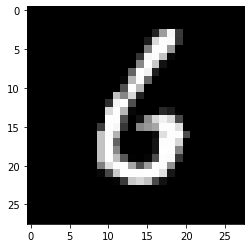

In [16]:
prd_img = load_model.predict_classes(x_test[50].reshape(-1,28,28,1))

plt.imshow(x_test[50].reshape(28, 28), cmap='gray')
print('---------------  0, 1, 2, 3, 4, 5, 6, 7, 8, 9',)
print('Actual label : ', y_test[50])
print('Predicted class : ',prd_img)

## References
- Ian McLoughlin Lecture notes and Videos
- [Converting MNIST dataset for Handwritten digit recognition.](https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1)
- [An intuitive guide to Convolutional Neural Networks.](https://medium.freecodecamp.org/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050)
- [Understanding of Convolutional Neural Network (CNN).](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148)
- [Keras Convolutional Layers](https://keras.io/layers/convolutional/)
- [Data Preprocessing for Machine learning in Python](https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/)
- [Encoding Categorical Values in Pythonm](https://pbpython.com/categorical-encoding.html)
- [Convolutional Neural Network](http://deeplearning.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/)
- [Loss functions](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions)